In [2]:
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
#from cnnfeat import get_feats

Using TensorFlow backend.


Initializing Magics


In [3]:
from cycliclr import CyclicLR
from math import ceil

In [31]:
from features import ToFeature
toFeature = ToFeature()
def get_feats(pos):
    toFeature.set_position(pos)
    return toFeature.ann_features()
def get_feats_stack(fens):
    return np.stack([get_feats(Position.from_fen(f)) for f in fens])

In [5]:
def dense_model():
    input_global = Input((26,))
    input_pawn = Input((18,))
    input_piece = Input((68,))
    input_square = Input((148,))
    g = Dense(26)(input_global)
    g = Activation('relu')(g)
    pwn = Dense(18)(input_pawn)
    pwn = Activation('relu')(pwn)
    pc = Dense(24)(input_piece)
    pc = Activation('relu')(pc)
    sq = Dense(32)(input_square)
    sq = Activation('relu')(sq)
    merged = keras.layers.concatenate([g, pwn, pc, sq])
    shared = Dense(64)(merged)
    shared = Activation('relu')(shared)
    output = Dense(1)(shared)
    output = Activation('tanh')(output)
    # 13997 params
    return [input_global, input_pawn, input_piece, input_square], output

In [75]:
inputs, output = dense_model()
model = Model(inputs, output)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 148)          0                                            
__________________________________________________________________________________________________
dense_1 (D

In [45]:
[len(l) for l in get_feats(Position.from_fen(fen))]

[26, 18, 68, 148]

In [76]:
def transform_features(features):
        m = len(features)
        dgs = np.zeros((m, 26))
        dpws = np.zeros((m, 18))
        dpcs = np.zeros((m, 68))
        dsqs = np.zeros((m, 148))
        for n, f in enumerate(features):
            dgs[n], dpws[n], dpcs[n], dsqs[n] = f
        return [dgs, dpws, dpcs, dsqs]

In [77]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = [get_feats(Position.from_fen(fen)) for fen in fens]
            score = np.array(batch.score, dtype='float32')
            yield transform_features(feats), score

In [150]:
model.compile(keras.optimizers.SGD(lr=.01, momentum=.99, nesterov=True), 'mse')

In [78]:
model.compile('adam', 'mse')

In [79]:
sf_scores_all = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')
sf_scores = sf_scores_all[:29570]
sf_scores_valid = sf_scores_all[-1024:]

In [80]:
wgts = model.get_weights()

In [159]:
model.set_weights(wgts)

In [70]:
# valid_gen = batch_generator_df(sf_scores_valid, batch_size, shuffle=False)
# valid_data = list(valid_gen)

KeyboardInterrupt: 

In [82]:
batch_size = 1024
#nvalid = len(features_sf12_valid)

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df(sf_scores, batch_size)
valid_gen = batch_generator_df(sf_scores_valid, batch_size, shuffle=False)

train_steps = ceil(len(sf_scores) / batch_size)
valid_steps = ceil(len(sf_scores_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
# checkpoint_path = '../slonik_data/weights.{epoch:03d}-{val_loss:.6f}.h5'
checkpoint_path = '../slonik_data/weights_best.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
clr = CyclicLR(base_lr=5e-6, max_lr=4e-3, step_size=train_steps*10, mode='triangular')
# clr = CyclicLR(base_lr=0, max_lr=1e-2, step_size=train_steps*5, mode='triangular')

# callbacks = [clr]
# callbacks = [clr, checkpoint]
callbacks = []
K.set_value(model.optimizer.lr, 1e-3)
hist = model.fit_generator(train_gen, train_steps, epochs=100, 
                          validation_data=valid_gen, validation_steps=valid_steps)

# K.set_value(model.optimizer.lr, 1e-5)
# model.fit_generator(train_gen, train_steps, epochs=2, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/100
 2/29 [=>............................] - ETA: 24s - loss: 0.1648

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129820). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 18s - loss: 0.1073

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101129). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 17s - loss: 0.1023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103766). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 16s - loss: 0.1005

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111457). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 14s - loss: 0.0933

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101328). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 11s - loss: 0.0774

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106039). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 10s - loss: 0.0707

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108618). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 8s - loss: 0.0666

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108495). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 8s - loss: 0.0647

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108403). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 6s - loss: 0.0582

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108585). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 5s - loss: 0.0563

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108800). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0520

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106144). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0483

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106412). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0471

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106494). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0460

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109138). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106603). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 22s 746ms/step - loss: 0.0449 - val_loss: 0.0167
Epoch 2/100
 2/29 [=>............................] - ETA: 2s - loss: 0.0158

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103305). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 4s - loss: 0.0164

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132183). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155045). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158053). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 0.0156

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134623). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 7s - loss: 0.0154

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114201). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 8s - loss: 0.0151

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109020). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 8s - loss: 0.0147

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103839). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0145

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103572). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0144

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108997). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 6s - loss: 0.0139

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101497). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0134

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106655). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0132

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114163). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0129

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114258). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0128

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114207). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0124

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109064). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0123

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108961). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0121

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111407). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106403). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 20s 678ms/step - loss: 0.0121 - val_loss: 0.0090
Epoch 3/100
13/29 [============>.................] - ETA: 7s - loss: 0.0084

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101319). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0080

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101123). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0079

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103661). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0078

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100872). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 20s 677ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 4/100
11/29 [==========>...................] - ETA: 9s - loss: 0.0059 

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101494). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 8s - loss: 0.0059

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106610). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 7s - loss: 0.0058

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108944). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0058

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103632). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 5s - loss: 0.0057

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103648). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0056

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101405). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 21s 735ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/100
 3/29 [==>...........................] - ETA: 2s - loss: 0.0045

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103715). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0044

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100993). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0043

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103224). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0043

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100932). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 20s 698ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 6/100
10/29 [=========>....................] - ETA: 9s - loss: 0.0039

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101483). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 9s - loss: 0.0039

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106373). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0038

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108854). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 7s - loss: 0.0038

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108976). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0038

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109028). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0037

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108909). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 5s - loss: 0.0037

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103477). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 4s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101689). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111637). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103937). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103741). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103974). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 21s 710ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 7/100
 3/29 [==>...........................] - ETA: 6s - loss: 0.0036

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108762). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111268). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109466). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111620). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 9s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113774). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 9s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113935). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 9s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114099). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 8s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114171). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0033

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114169). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114476). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114602). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111903). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111629). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114473). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0032

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111487). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106273). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 671ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 8/100
 2/29 [=>............................] - ETA: 2s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124842). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145233). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 3s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139611). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 5s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132226). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124747). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 8s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124652). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0031

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119450). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114220). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111077). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108812). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108608). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106207). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106609). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111381). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111418). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111342). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109018). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106646). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 652ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 9/100
 3/29 [==>...........................] - ETA: 2s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102547). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 5s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103272). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 7s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103997). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106682). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 8s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104327). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 8s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106847). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104162). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 7s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111933). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119036). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 6s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109412). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109407). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109285). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114328). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109126). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104024). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101460). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 654ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 10/100
 3/29 [==>...........................] - ETA: 2s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139449). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 8s - loss: 0.0027

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104120). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 8s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106387). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 8s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108655). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108921). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111801). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 7s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116451). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118607). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118729). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119014). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116647). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108984). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101372). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106709). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109210). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103906). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 669ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 11/100
 4/29 [===>..........................] - ETA: 4s - loss: 0.0034

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106455). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 0.0030

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114066). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 7s - loss: 0.0028

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108993). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 8s - loss: 0.0027

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116721). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 7s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121990). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 7s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114262). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108985). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108811). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0024

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103909). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109024). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0022

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111589). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0022

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114033). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108808). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 20s 674ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 12/100
14/29 [=============>................] - ETA: 6s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100828). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 6s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105470). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110601). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 4s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108003). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100318). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100302). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102856). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100819). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106249). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114392). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 647ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 13/100
 2/29 [=>............................] - ETA: 0s - loss: 0.003 - ETA: 1s - loss: 0.0037

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157853). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 7s - loss: 0.0027

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105687). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 8s - loss: 0.0026

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113156). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108693). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113593). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 9s - loss: 0.0022

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111070). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106608). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104154). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106531). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111761). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109307). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114075). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108845). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108898). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114082). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103972). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103555). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 649ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 14/100
 2/29 [=>............................] - ETA: 1s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118739). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101475). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106612). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109282). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111555). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113968). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113827). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111414). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111477). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113717). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109240). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111612). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 662ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 15/100
 3/29 [==>...........................] - ETA: 3s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175971). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103140). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135085). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 6s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124375). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 7s - loss: 0.0018

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113665). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 8s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111309). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 8s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109398). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 8s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111531). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109272). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111729). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111677). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114077). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116528). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121814). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114145). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111295). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101269). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 657ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 16/100
 2/29 [=>............................] - ETA: 1s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121706). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 5s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124525). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 8s - loss: 0.0018

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119018). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 9s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119587). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116899). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114210). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113860). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 9s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114341). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 8s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108889). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109239). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104122). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109369). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116711). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116781). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119125). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119391). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116956). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117047). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106894). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 20s 689ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 17/100
 2/29 [=>............................] - ETA: 2s - loss: 0.0029

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103946). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 4s - loss: 0.0025

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143017). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 7s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119478). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111712). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 8s - loss: 0.0021

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108841). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 8s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108901). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0018

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108960). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111691). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109019). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108900). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106130). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106248). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103822). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104087). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106580). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 669ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 18/100
 6/29 [=====>........................] - ETA: 9s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101111). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0018

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108434). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0018

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111345). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 9s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114257). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121539). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 8s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121701). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124430). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121955). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111747). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119451). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116672). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119363). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116495). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103653). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 642ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 19/100
10/29 [=========>....................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103908). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108755). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109115). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111823). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116690). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111860). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114089). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119100). Check your callbacks.
  % delta_t_median)


24/29 [=======================>......] - ETA: 2s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114269). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114349). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116703). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108905). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 651ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 20/100
 2/29 [=>............................] - ETA: 1s - loss: 0.0020

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134259). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 4s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155776). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 7s - loss: 0.0016

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124544). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 8s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123778). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114541). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106222). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111776). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 7s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109036). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108940). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108931). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103856). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101209). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106284). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 639ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 21/100
 3/29 [==>...........................] - ETA: 5s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103983). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109127). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 8s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114271). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116633). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118994). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 9s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114661). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 9s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114466). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116828). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119119). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114369). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117098). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121509). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116235). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106444). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114112). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114012). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106139). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100636). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 644ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 22/100
 2/29 [=>............................] - ETA: 2s - loss: 0.0019

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119078). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127080). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 7s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126856). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 8s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124095). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121587). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114206). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109335). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109063). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106383). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109346). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111790). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114365). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116766). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119244). Check your callbacks.
  % delta_t_median)


26/29 [=========================>....] - ETA: 1s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111841). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111670). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109154). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109104). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 652ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 23/100
 3/29 [==>...........................] - ETA: 4s - loss: 0.0019- ETA: 2s - loss: 0.002

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130080). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171117). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 6s - loss: 0.0017

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132457). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 8s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108540). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 8s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118822). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119073). Check your callbacks.
  % delta_t_median)


10/29 [=========>....................] - ETA: 8s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111011). Check your callbacks.
  % delta_t_median)


12/29 [===========>..................] - ETA: 8s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111200). Check your callbacks.
  % delta_t_median)


13/29 [============>.................] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103389). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 7s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111575). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109361). Check your callbacks.
  % delta_t_median)


18/29 [=================>............] - ETA: 5s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103953). Check your callbacks.
  % delta_t_median)


19/29 [==================>...........] - ETA: 5s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106589). Check your callbacks.
  % delta_t_median)


20/29 [===================>..........] - ETA: 4s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111623). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111748). Check your callbacks.
  % delta_t_median)


25/29 [========================>.....] - ETA: 2s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111536). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110329). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 19s 666ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 24/100
 3/29 [==>...........................] - ETA: 3s - loss: 0.0014- ETA: 1s - loss: 0.001

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155127). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114558). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 4s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106726). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 6s - loss: 0.0014

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114200). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114063). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 7s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113926). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 7s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114379). Check your callbacks.
  % delta_t_median)


14/29 [=============>................] - ETA: 7s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116753). Check your callbacks.
  % delta_t_median)


15/29 [==============>...............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116616). Check your callbacks.
  % delta_t_median)


16/29 [===============>..............] - ETA: 6s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116602). Check your callbacks.
  % delta_t_median)


17/29 [================>.............] - ETA: 5s - loss: 0.0012

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119339). Check your callbacks.
  % delta_t_median)


21/29 [====================>.........] - ETA: 4s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114421). Check your callbacks.
  % delta_t_median)


22/29 [=====================>........] - ETA: 3s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116874). Check your callbacks.
  % delta_t_median)


23/29 [======================>.......] - ETA: 3s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114337). Check your callbacks.
  % delta_t_median)


27/29 [==========================>...] - ETA: 1s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111856). Check your callbacks.
  % delta_t_median)


28/29 [===========================>..] - ETA: 0s - loss: 0.0011

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109418). Check your callbacks.
  % delta_t_median)
/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106787). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 18s 637ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 25/100
 2/29 [=>............................] - ETA: 1s - loss: 0.0023

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109046). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 8s - loss: 0.0015

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104267). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111749). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109319). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109061). Check your callbacks.
  % delta_t_median)


 9/29 [========>.....................] - ETA: 9s - loss: 0.0013

/usr/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108803). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 8s - loss: 0.0012

KeyboardInterrupt: 

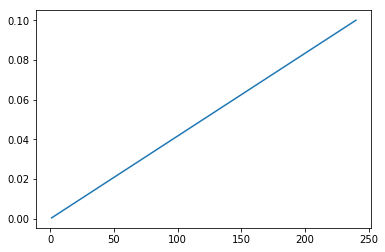

In [153]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [83]:
rng = np.s_[::train_steps*10]
plt.plot(clr.history['iterations'][rng], clr.history['loss'][rng])

KeyError: 'iterations'

In [85]:
rng = np.s_[::10*2]
fig = plt.plot(np.arange(len(hist.history['loss'][rng])), hist.history['loss'][rng], 'b'); fig
plt.plot(np.arange(len(hist.history['loss'][rng])), hist.history['val_loss'][rng], 'g')

NameError: name 'hist' is not defined

### evaluate models

In [84]:
batch_size = 1024 * 2
valid_steps = ceil(len(sf_scores_valid) / batch_size)
valid_gen = batch_generator_df(sf_scores_valid, batch_size, shuffle=False)
model.evaluate_generator(valid_gen, steps=valid_steps)
# train_model.metrics_names
# K.get_value(train_model.optimizer.lr)
# 0.0010100496762121718 adam clr

0.001229084562510252

In [175]:
model.load_weights('../slonik_data/weights_best.h5')

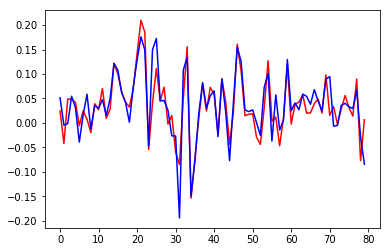

In [86]:
rng = slice(0,80)
fens = sf_scores_valid[rng].fen
scores = sf_scores_valid[rng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(transform_features([get_feats(Position.from_fen(f)) for f in fens])), 'b')

In [19]:
model.predict(features_sf3_valid_sample[rng]).shape

(40, 8, 8, 1)

In [85]:
n = 28
print(Position.from_fen(sf_scores3.iloc[-60000+n].fen))
print(sf_scores3.iloc[-60000+n].score)
model.predict(features_sf3_valid_sample[n][None])

W to move
 ·  ·  ·  ·  ·  ·  ♚  · 
 ·  ·  ·  ·  ·  ♟  ·  ♟ 
 ·  ·  ♟  ·  ♙  ·  ·  · 
 ·  ·  ·  ♞  ·  ·  ·  · 
 ·  ·  ·  ♕  ·  ♙  ·  · 
 ·  ·  ·  ·  ·  ♙  ·  ♙ 
 ♙  ·  ·  ·  ·  ·  ·  ♔ 
 ·  ·  ·  ♝  ♛  ·  ·  · 

-0.0633715525256


array([[-0.00351094]], dtype=float32)